In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
torch.manual_seed(42)
import matplotlib.pyplot as plt
from PIL import Image
import skimage
np.random.seed(42)
torch.manual_seed(42)

In [2]:
import cv2

In [3]:
class relu_mlp(nn.Module):
  def __init__(self, neurons, h_layers):
    super(relu_mlp, self).__init__()
    self.neurons = neurons
    self.h_layers = h_layers

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(2,neurons))
    for i in range (h_layers-1):
      self.layers.append(nn.Linear(neurons,neurons))
    self.layers.append(nn.Linear(neurons, 1))
  
  def forward (self,x):
    for layer in self.layers[:-1]:
      x = F.relu(layer(x))
    x = self.layers[-1](x)
    return x

In [4]:
class siren_mlp(nn.Module):
  def __init__(self, neurons, h_layers, omega):
    super(siren_mlp, self).__init__()
    self.neurons = neurons
    self.h_layers = h_layers
    self.omega = omega

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(2, neurons))
    for i in range(h_layers-1):
      self.layers.append(nn.Linear(neurons, neurons))
    self.layers.append(nn.Linear(neurons,1))

    nn.init.uniform_(self.layers[0].weight,-1/2,1/2)
    for layer in self.layers[1:]:
      nn.init.uniform_(layer.weight,-np.sqrt(6/neurons)/omega, np.sqrt(6/neurons)/omega)
  
  def forward (self, x):
    for layer in self.layers[:-1]:
      x = torch.sin(layer(x))
    x = self.layers[-1](x)
    return x

In [5]:
def coordinates (n):
  # Create an empty list to store the tuples
  tuples = []

  # Iterate over all x and y values from 0 to 512
  for x in range(n):
      for y in range(n):
          # Append the current tuple to the list
          tuples.append([x, y])

  # Convert the list to a NumPy array if desired
  tuples_array = np.array(tuples)
  return tuples_array

In [6]:
img = Image.fromarray(skimage.data.camera())        

In [7]:
img = img.resize((256,256))

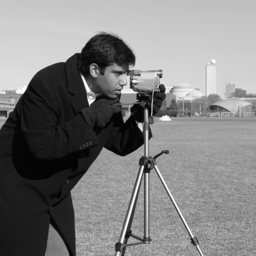

In [8]:
img

In [10]:
image_array = np.asarray(img)
image_array_rescaled = (image_array-127.5)/127.5

In [235]:
import cv2

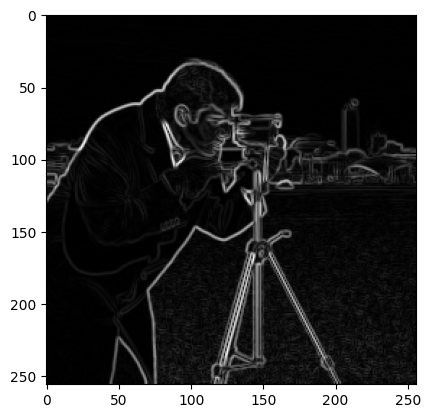

In [238]:
sobel_x = cv2.Sobel(image_array, cv2.CV_64F, 1, 0, ksize=3)

# Apply the Sobel filter in the y direction
sobel_y = cv2.Sobel(image_array, cv2.CV_64F, 0, 1, ksize=3)

# Compute the magnitude of the gradient
mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
plt.imshow(mag, cmap = "gray")

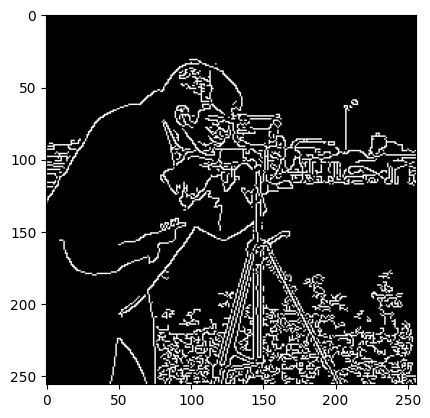

In [11]:
img_gradient = cv2.Canny(image_array.astype('uint8'),50,150)
plt.imshow(img_gradient, cmap = "gray")

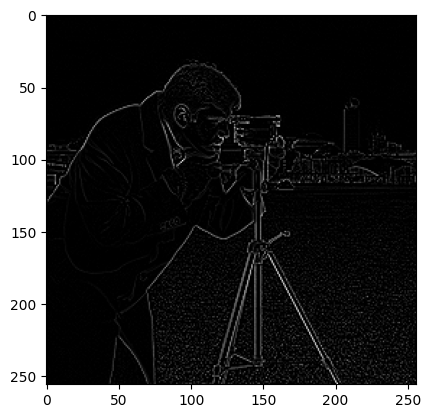

In [12]:
img_laplacian = cv2.Laplacian(image_array.astype('uint8'),50,150)
plt.imshow(img_laplacian, cmap = "gray")

In [13]:
from tqdm import tqdm

In [14]:
device = 'cuda'

In [15]:
torch.cuda.is_available()

True

In [25]:
relu_model = relu_mlp(256,4).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(relu_model.parameters(), lr=0.0001)

In [155]:
X = coordinates(256)
y = image_array_rescaled.reshape(-1)

In [27]:
relu_psnr = []

In [29]:
num_epochs = 15000
for e in tqdm(range(num_epochs)):
  y_pred_train = relu_model(torch.from_numpy(X.astype('float32')).to(device)).squeeze()
  loss = criterion(y_pred_train, torch.from_numpy(y.astype('float32')).to(device)) # loss is a tensor which stores the current value of train loss
  relu_psnr.append(20 * np.log10(1.0 / np.sqrt(loss.item())))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 100 == 0:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss
  if e == num_epochs-1:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss

  0%|          | 6/15000 [00:00<08:39, 28.87it/s]

Epoch [0/15000], Loss: 2.1505


  1%|          | 106/15000 [00:02<06:22, 38.93it/s]

Epoch [100/15000], Loss: 0.1971


  1%|▏         | 206/15000 [00:05<06:25, 38.38it/s]

Epoch [200/15000], Loss: 0.1887


  2%|▏         | 306/15000 [00:07<06:23, 38.29it/s]

Epoch [300/15000], Loss: 0.1739


  3%|▎         | 407/15000 [00:10<06:22, 38.20it/s]

Epoch [400/15000], Loss: 0.1587


  3%|▎         | 507/15000 [00:13<06:19, 38.14it/s]

Epoch [500/15000], Loss: 0.1448


  4%|▍         | 607/15000 [00:15<06:17, 38.13it/s]

Epoch [600/15000], Loss: 0.1280


  5%|▍         | 707/15000 [00:18<06:17, 37.82it/s]

Epoch [700/15000], Loss: 0.1160


  5%|▌         | 807/15000 [00:21<06:15, 37.76it/s]

Epoch [800/15000], Loss: 0.1010


  6%|▌         | 907/15000 [00:23<06:13, 37.75it/s]

Epoch [900/15000], Loss: 0.1172


  7%|▋         | 1007/15000 [00:26<06:11, 37.70it/s]

Epoch [1000/15000], Loss: 0.0911


  7%|▋         | 1107/15000 [00:29<06:13, 37.19it/s]

Epoch [1100/15000], Loss: 0.0890


  8%|▊         | 1207/15000 [00:31<06:10, 37.23it/s]

Epoch [1200/15000], Loss: 0.0835


  9%|▊         | 1307/15000 [00:34<06:08, 37.13it/s]

Epoch [1300/15000], Loss: 0.0813


  9%|▉         | 1407/15000 [00:37<06:04, 37.32it/s]

Epoch [1400/15000], Loss: 0.0809


 10%|█         | 1507/15000 [00:39<06:03, 37.14it/s]

Epoch [1500/15000], Loss: 0.0827


 11%|█         | 1607/15000 [00:42<06:02, 36.99it/s]

Epoch [1600/15000], Loss: 0.0790


 11%|█▏        | 1707/15000 [00:45<05:58, 37.12it/s]

Epoch [1700/15000], Loss: 0.0796


 12%|█▏        | 1807/15000 [00:47<05:57, 36.87it/s]

Epoch [1800/15000], Loss: 0.0899


 13%|█▎        | 1907/15000 [00:50<05:55, 36.79it/s]

Epoch [1900/15000], Loss: 0.0739


 13%|█▎        | 2007/15000 [00:53<05:54, 36.68it/s]

Epoch [2000/15000], Loss: 0.0727


 14%|█▍        | 2107/15000 [00:56<05:54, 36.42it/s]

Epoch [2100/15000], Loss: 0.0716


 15%|█▍        | 2207/15000 [00:58<05:53, 36.24it/s]

Epoch [2200/15000], Loss: 0.0794


 15%|█▌        | 2307/15000 [01:01<05:50, 36.17it/s]

Epoch [2300/15000], Loss: 0.0690


 16%|█▌        | 2407/15000 [01:04<06:19, 33.16it/s]

Epoch [2400/15000], Loss: 0.0699


 17%|█▋        | 2507/15000 [01:07<05:49, 35.77it/s]

Epoch [2500/15000], Loss: 0.0672


 17%|█▋        | 2607/15000 [01:10<05:46, 35.77it/s]

Epoch [2600/15000], Loss: 0.0661


 18%|█▊        | 2707/15000 [01:12<05:39, 36.17it/s]

Epoch [2700/15000], Loss: 0.0656


 19%|█▊        | 2807/15000 [01:15<05:49, 34.92it/s]

Epoch [2800/15000], Loss: 0.0686


 19%|█▉        | 2907/15000 [01:18<05:41, 35.43it/s]

Epoch [2900/15000], Loss: 0.0698


 20%|██        | 3007/15000 [01:21<05:31, 36.19it/s]

Epoch [3000/15000], Loss: 0.0749


 21%|██        | 3107/15000 [01:24<05:27, 36.35it/s]

Epoch [3100/15000], Loss: 0.0694


 21%|██▏       | 3207/15000 [01:26<05:24, 36.36it/s]

Epoch [3200/15000], Loss: 0.0644


 22%|██▏       | 3307/15000 [01:29<05:21, 36.43it/s]

Epoch [3300/15000], Loss: 0.0644


 23%|██▎       | 3407/15000 [01:32<05:17, 36.56it/s]

Epoch [3400/15000], Loss: 0.0691


 23%|██▎       | 3507/15000 [01:35<05:13, 36.68it/s]

Epoch [3500/15000], Loss: 0.0603


 24%|██▍       | 3607/15000 [01:37<05:10, 36.69it/s]

Epoch [3600/15000], Loss: 0.0607


 25%|██▍       | 3707/15000 [01:40<05:08, 36.57it/s]

Epoch [3700/15000], Loss: 0.0609


 25%|██▌       | 3807/15000 [01:43<05:03, 36.83it/s]

Epoch [3800/15000], Loss: 0.0655


 26%|██▌       | 3907/15000 [01:46<05:04, 36.45it/s]

Epoch [3900/15000], Loss: 0.0573


 27%|██▋       | 4007/15000 [01:48<04:57, 36.93it/s]

Epoch [4000/15000], Loss: 0.0634


 27%|██▋       | 4107/15000 [01:51<04:55, 36.86it/s]

Epoch [4100/15000], Loss: 0.0565


 28%|██▊       | 4207/15000 [01:54<04:52, 36.86it/s]

Epoch [4200/15000], Loss: 0.0550


 29%|██▊       | 4307/15000 [01:56<04:50, 36.77it/s]

Epoch [4300/15000], Loss: 0.0571


 29%|██▉       | 4407/15000 [01:59<04:54, 36.03it/s]

Epoch [4400/15000], Loss: 0.0606


 30%|███       | 4507/15000 [02:02<04:45, 36.82it/s]

Epoch [4500/15000], Loss: 0.0539


 31%|███       | 4607/15000 [02:05<04:41, 36.94it/s]

Epoch [4600/15000], Loss: 0.0544


 31%|███▏      | 4707/15000 [02:07<04:39, 36.83it/s]

Epoch [4700/15000], Loss: 0.0580


 32%|███▏      | 4807/15000 [02:10<04:38, 36.61it/s]

Epoch [4800/15000], Loss: 0.0580


 33%|███▎      | 4907/15000 [02:13<04:34, 36.75it/s]

Epoch [4900/15000], Loss: 0.0542


 33%|███▎      | 5007/15000 [02:15<04:34, 36.35it/s]

Epoch [5000/15000], Loss: 0.0511


 34%|███▍      | 5107/15000 [02:18<04:29, 36.64it/s]

Epoch [5100/15000], Loss: 0.0529


 35%|███▍      | 5207/15000 [02:21<04:28, 36.44it/s]

Epoch [5200/15000], Loss: 0.0472


 35%|███▌      | 5307/15000 [02:24<04:26, 36.33it/s]

Epoch [5300/15000], Loss: 0.0497


 36%|███▌      | 5407/15000 [02:26<04:23, 36.45it/s]

Epoch [5400/15000], Loss: 0.0599


 37%|███▋      | 5507/15000 [02:29<04:21, 36.35it/s]

Epoch [5500/15000], Loss: 0.0508


 37%|███▋      | 5607/15000 [02:32<04:18, 36.33it/s]

Epoch [5600/15000], Loss: 0.0547


 38%|███▊      | 5707/15000 [02:35<04:16, 36.30it/s]

Epoch [5700/15000], Loss: 0.0448


 39%|███▊      | 5807/15000 [02:37<04:13, 36.28it/s]

Epoch [5800/15000], Loss: 0.0478


 39%|███▉      | 5907/15000 [02:40<04:09, 36.48it/s]

Epoch [5900/15000], Loss: 0.0458


 40%|████      | 6007/15000 [02:43<04:07, 36.36it/s]

Epoch [6000/15000], Loss: 0.0474


 41%|████      | 6107/15000 [02:46<04:05, 36.29it/s]

Epoch [6100/15000], Loss: 0.0470


 41%|████▏     | 6207/15000 [02:48<04:04, 35.95it/s]

Epoch [6200/15000], Loss: 0.0490


 42%|████▏     | 6307/15000 [02:51<03:58, 36.38it/s]

Epoch [6300/15000], Loss: 0.0427


 43%|████▎     | 6407/15000 [02:54<03:55, 36.50it/s]

Epoch [6400/15000], Loss: 0.0466


 43%|████▎     | 6507/15000 [02:57<03:52, 36.55it/s]

Epoch [6500/15000], Loss: 0.0462


 44%|████▍     | 6607/15000 [02:59<03:49, 36.58it/s]

Epoch [6600/15000], Loss: 0.0455


 45%|████▍     | 6707/15000 [03:02<03:49, 36.20it/s]

Epoch [6700/15000], Loss: 0.0488


 45%|████▌     | 6807/15000 [03:05<03:44, 36.53it/s]

Epoch [6800/15000], Loss: 0.0446


 46%|████▌     | 6907/15000 [03:08<03:41, 36.52it/s]

Epoch [6900/15000], Loss: 0.0481


 47%|████▋     | 7007/15000 [03:10<03:38, 36.65it/s]

Epoch [7000/15000], Loss: 0.0412


 47%|████▋     | 7107/15000 [03:13<03:35, 36.56it/s]

Epoch [7100/15000], Loss: 0.0420


 48%|████▊     | 7207/15000 [03:16<03:33, 36.54it/s]

Epoch [7200/15000], Loss: 0.0399


 49%|████▊     | 7307/15000 [03:19<03:29, 36.80it/s]

Epoch [7300/15000], Loss: 0.0418


 49%|████▉     | 7407/15000 [03:21<03:28, 36.44it/s]

Epoch [7400/15000], Loss: 0.0478


 50%|█████     | 7507/15000 [03:24<03:26, 36.34it/s]

Epoch [7500/15000], Loss: 0.0449


 51%|█████     | 7607/15000 [03:27<03:24, 36.19it/s]

Epoch [7600/15000], Loss: 0.0452


 51%|█████▏    | 7707/15000 [03:29<03:19, 36.58it/s]

Epoch [7700/15000], Loss: 0.0429


 52%|█████▏    | 7807/15000 [03:32<03:17, 36.34it/s]

Epoch [7800/15000], Loss: 0.0392


 53%|█████▎    | 7907/15000 [03:35<03:14, 36.47it/s]

Epoch [7900/15000], Loss: 0.0437


 53%|█████▎    | 8007/15000 [03:38<03:12, 36.25it/s]

Epoch [8000/15000], Loss: 0.0407


 54%|█████▍    | 8107/15000 [03:41<03:09, 36.39it/s]

Epoch [8100/15000], Loss: 0.0401


 55%|█████▍    | 8207/15000 [03:43<03:06, 36.41it/s]

Epoch [8200/15000], Loss: 0.0388


 55%|█████▌    | 8307/15000 [03:46<03:04, 36.33it/s]

Epoch [8300/15000], Loss: 0.0372


 56%|█████▌    | 8407/15000 [03:49<03:00, 36.62it/s]

Epoch [8400/15000], Loss: 0.0369


 57%|█████▋    | 8507/15000 [03:51<02:58, 36.46it/s]

Epoch [8500/15000], Loss: 0.0393


 57%|█████▋    | 8607/15000 [03:54<02:54, 36.64it/s]

Epoch [8600/15000], Loss: 0.0521


 58%|█████▊    | 8707/15000 [03:57<02:52, 36.40it/s]

Epoch [8700/15000], Loss: 0.0379


 59%|█████▊    | 8807/15000 [04:00<02:48, 36.69it/s]

Epoch [8800/15000], Loss: 0.0388


 59%|█████▉    | 8907/15000 [04:02<02:47, 36.43it/s]

Epoch [8900/15000], Loss: 0.0427


 60%|██████    | 9007/15000 [04:05<02:45, 36.26it/s]

Epoch [9000/15000], Loss: 0.0377


 61%|██████    | 9107/15000 [04:08<02:42, 36.17it/s]

Epoch [9100/15000], Loss: 0.0396


 61%|██████▏   | 9207/15000 [04:11<02:39, 36.42it/s]

Epoch [9200/15000], Loss: 0.0381


 62%|██████▏   | 9307/15000 [04:13<02:36, 36.39it/s]

Epoch [9300/15000], Loss: 0.0421


 63%|██████▎   | 9407/15000 [04:16<02:34, 36.29it/s]

Epoch [9400/15000], Loss: 0.0431


 63%|██████▎   | 9507/15000 [04:19<02:31, 36.24it/s]

Epoch [9500/15000], Loss: 0.0386


 64%|██████▍   | 9607/15000 [04:22<02:27, 36.59it/s]

Epoch [9600/15000], Loss: 0.0407


 65%|██████▍   | 9707/15000 [04:24<02:25, 36.31it/s]

Epoch [9700/15000], Loss: 0.0354


 65%|██████▌   | 9807/15000 [04:27<02:22, 36.39it/s]

Epoch [9800/15000], Loss: 0.0354


 66%|██████▌   | 9907/15000 [04:30<02:20, 36.21it/s]

Epoch [9900/15000], Loss: 0.0355


 67%|██████▋   | 10007/15000 [04:33<02:16, 36.65it/s]

Epoch [10000/15000], Loss: 0.0376


 67%|██████▋   | 10107/15000 [04:35<02:14, 36.47it/s]

Epoch [10100/15000], Loss: 0.0348


 68%|██████▊   | 10207/15000 [04:38<02:10, 36.60it/s]

Epoch [10200/15000], Loss: 0.0394


 69%|██████▊   | 10307/15000 [04:41<02:07, 36.79it/s]

Epoch [10300/15000], Loss: 0.0417


 69%|██████▉   | 10407/15000 [04:44<02:04, 36.80it/s]

Epoch [10400/15000], Loss: 0.0412


 70%|███████   | 10507/15000 [04:46<02:02, 36.76it/s]

Epoch [10500/15000], Loss: 0.0347


 71%|███████   | 10607/15000 [04:49<01:59, 36.80it/s]

Epoch [10600/15000], Loss: 0.0376


 71%|███████▏  | 10707/15000 [04:52<01:56, 36.90it/s]

Epoch [10700/15000], Loss: 0.0456


 72%|███████▏  | 10807/15000 [04:54<01:53, 36.90it/s]

Epoch [10800/15000], Loss: 0.0348


 73%|███████▎  | 10907/15000 [04:57<01:50, 36.91it/s]

Epoch [10900/15000], Loss: 0.0420


 73%|███████▎  | 11007/15000 [05:00<01:48, 36.93it/s]

Epoch [11000/15000], Loss: 0.0348


 74%|███████▍  | 11107/15000 [05:03<01:45, 36.87it/s]

Epoch [11100/15000], Loss: 0.0336


 75%|███████▍  | 11207/15000 [05:05<01:42, 36.90it/s]

Epoch [11200/15000], Loss: 0.0341


 75%|███████▌  | 11307/15000 [05:08<01:40, 36.84it/s]

Epoch [11300/15000], Loss: 0.0358


 76%|███████▌  | 11407/15000 [05:11<01:37, 37.00it/s]

Epoch [11400/15000], Loss: 0.0381


 77%|███████▋  | 11507/15000 [05:13<01:34, 36.90it/s]

Epoch [11500/15000], Loss: 0.0384


 77%|███████▋  | 11607/15000 [05:16<01:31, 36.96it/s]

Epoch [11600/15000], Loss: 0.0348


 78%|███████▊  | 11707/15000 [05:19<01:29, 36.67it/s]

Epoch [11700/15000], Loss: 0.0319


 79%|███████▊  | 11807/15000 [05:22<01:26, 36.87it/s]

Epoch [11800/15000], Loss: 0.0385


 79%|███████▉  | 11907/15000 [05:24<01:23, 36.96it/s]

Epoch [11900/15000], Loss: 0.0330


 80%|████████  | 12007/15000 [05:27<01:21, 36.93it/s]

Epoch [12000/15000], Loss: 0.0328


 81%|████████  | 12107/15000 [05:30<01:18, 36.95it/s]

Epoch [12100/15000], Loss: 0.0355


 81%|████████▏ | 12207/15000 [05:32<01:15, 36.78it/s]

Epoch [12200/15000], Loss: 0.0315


 82%|████████▏ | 12307/15000 [05:35<01:13, 36.80it/s]

Epoch [12300/15000], Loss: 0.0316


 83%|████████▎ | 12407/15000 [05:38<01:10, 36.74it/s]

Epoch [12400/15000], Loss: 0.0336


 83%|████████▎ | 12507/15000 [05:41<01:07, 36.76it/s]

Epoch [12500/15000], Loss: 0.0313


 84%|████████▍ | 12607/15000 [05:43<01:05, 36.76it/s]

Epoch [12600/15000], Loss: 0.0313


 85%|████████▍ | 12707/15000 [05:46<01:02, 36.55it/s]

Epoch [12700/15000], Loss: 0.0329


 85%|████████▌ | 12807/15000 [05:49<00:59, 36.83it/s]

Epoch [12800/15000], Loss: 0.0326


 86%|████████▌ | 12907/15000 [05:51<00:56, 36.72it/s]

Epoch [12900/15000], Loss: 0.0353


 87%|████████▋ | 13007/15000 [05:54<00:54, 36.77it/s]

Epoch [13000/15000], Loss: 0.0336


 87%|████████▋ | 13107/15000 [05:57<00:51, 36.93it/s]

Epoch [13100/15000], Loss: 0.0364


 88%|████████▊ | 13207/15000 [06:00<00:48, 36.69it/s]

Epoch [13200/15000], Loss: 0.0313


 89%|████████▊ | 13307/15000 [06:02<00:46, 36.59it/s]

Epoch [13300/15000], Loss: 0.0395


 89%|████████▉ | 13407/15000 [06:05<00:43, 36.83it/s]

Epoch [13400/15000], Loss: 0.0351


 90%|█████████ | 13507/15000 [06:08<00:40, 36.94it/s]

Epoch [13500/15000], Loss: 0.0338


 91%|█████████ | 13607/15000 [06:10<00:37, 36.77it/s]

Epoch [13600/15000], Loss: 0.0347


 91%|█████████▏| 13707/15000 [06:13<00:34, 36.95it/s]

Epoch [13700/15000], Loss: 0.0374


 92%|█████████▏| 13807/15000 [06:16<00:32, 36.63it/s]

Epoch [13800/15000], Loss: 0.0358


 93%|█████████▎| 13907/15000 [06:19<00:29, 36.85it/s]

Epoch [13900/15000], Loss: 0.0340


 93%|█████████▎| 14007/15000 [06:21<00:26, 36.90it/s]

Epoch [14000/15000], Loss: 0.0312


 94%|█████████▍| 14107/15000 [06:24<00:24, 36.79it/s]

Epoch [14100/15000], Loss: 0.0341


 95%|█████████▍| 14207/15000 [06:27<00:21, 36.93it/s]

Epoch [14200/15000], Loss: 0.0311


 95%|█████████▌| 14307/15000 [06:29<00:18, 37.06it/s]

Epoch [14300/15000], Loss: 0.0372


 96%|█████████▌| 14407/15000 [06:32<00:16, 36.86it/s]

Epoch [14400/15000], Loss: 0.0323


 97%|█████████▋| 14507/15000 [06:35<00:13, 36.90it/s]

Epoch [14500/15000], Loss: 0.0299


 97%|█████████▋| 14607/15000 [06:38<00:10, 36.89it/s]

Epoch [14600/15000], Loss: 0.0379


 98%|█████████▊| 14707/15000 [06:40<00:07, 36.80it/s]

Epoch [14700/15000], Loss: 0.0303


 99%|█████████▊| 14807/15000 [06:43<00:05, 36.91it/s]

Epoch [14800/15000], Loss: 0.0314


 99%|█████████▉| 14907/15000 [06:46<00:02, 37.01it/s]

Epoch [14900/15000], Loss: 0.0299


100%|██████████| 15000/15000 [06:48<00:00, 36.70it/s]

Epoch [14999/15000], Loss: 0.0336


In [185]:
len(relu_psnr)

15000

In [249]:
y_preds = relu_model(torch.from_numpy(X.astype('float32')).to(device))

In [250]:
y_image_values = (y_preds.cpu().detach().numpy().reshape(256,256)*127.5)+127.5
y_image_values

array([[201.11877 , 200.44943 , 200.89659 , ..., 188.37503 , 188.45763 ,
        188.53986 ],
       [200.5986  , 200.32593 , 199.91324 , ..., 188.17633 , 188.28854 ,
        188.40747 ],
       [201.39085 , 200.99847 , 198.5517  , ..., 188.17741 , 188.2965  ,
        188.43513 ],
       ...,
       [ 20.553314,  21.208565,  21.894684, ..., 137.47815 , 137.09634 ,
        137.57239 ],
       [ 20.323967,  20.97828 ,  21.66394 , ..., 138.20651 , 137.33551 ,
        136.95142 ],
       [ 20.093903,  20.747704,  21.433228, ..., 138.44853 , 138.064   ,
        137.19278 ]], dtype=float32)

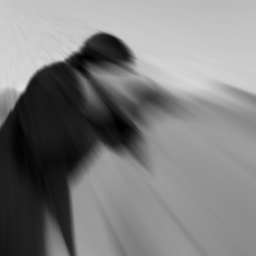

In [251]:
relu_img = Image.fromarray(y_image_values)
relu_img.show()

In [253]:
X_temp = torch.tensor(X.astype('float32'), requires_grad = True).to(device)
y_preds = relu_model(X_temp).to(device)

In [254]:
grad_ = torch.autograd.grad(y_preds, X_temp,grad_outputs = torch.ones_like(y_preds), create_graph=True)[0]

In [255]:
grad__ = torch.autograd.grad(y_preds, X_temp,grad_outputs = torch.ones_like(y_preds), create_graph=True, retain_graph = True)[0]

In [256]:
type(grad_), grad_.shape

(torch.Tensor, torch.Size([65536, 2]))

In [257]:
grad_array = grad_.cpu().detach().numpy()
grad_array

array([[ 0.22124697,  0.2259976 ],
       [ 0.03029942, -0.10622869],
       [ 0.10983539, -0.01335932],
       ...,
       [ 0.00149709, -0.00259469],
       [ 0.00571431, -0.00683199],
       [ 0.00571431, -0.00683199]], dtype=float32)

In [258]:
grad_array.shape

(65536, 2)

In [259]:
grad_x = grad_array[:, 0].reshape(-1, 1)
grad_y = grad_array[:, 1].reshape(-1, 1)

In [260]:
grad_x = grad_x.reshape(256,256)
grad_y = grad_y.reshape(256,256)
grad_x = (grad_x*127.5) + 127.5
grad_y = (grad_y*127.5) + 127.5

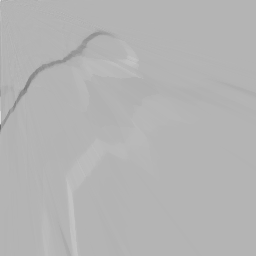

In [261]:
gradient_image_relu = np.sqrt(grad_x**2 + grad_y**2)
gradient_actual_relu = Image.fromarray(gradient_image_relu.astype('uint8'))
gradient_actual_relu

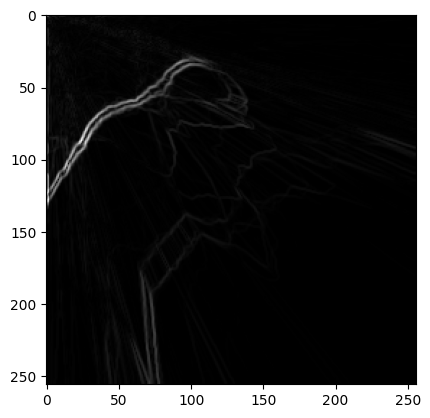

In [263]:
sobel_x = cv2.Sobel(gradient_image_relu, cv2.CV_64F, 1, 0, ksize=3)

# Apply the Sobel filter in the y direction
sobel_y = cv2.Sobel(gradient_image_relu, cv2.CV_64F, 0, 1, ksize=3)

# Compute the magnitude of the gradient
grad_relu = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
plt.imshow(grad_relu, cmap = "gray")

array([[220.63448, 173.9029 , 189.33618, ..., 180.22684, 180.22684,
        180.22684],
       [194.59306, 169.92296, 175.80316, ..., 180.23657, 180.40912,
        180.40912],
       [181.28276, 177.02325, 182.56775, ..., 180.38954, 180.38954,
        180.53941],
       ...,
       [180.56906, 180.63493, 180.48515, ..., 180.21501, 180.21107,
        180.2109 ],
       [180.56906, 180.63493, 180.63493, ..., 180.21501, 180.21501,
        180.21107],
       [180.56906, 180.63493, 180.63493, ..., 180.21365, 180.21501,
        180.21501]], dtype=float32)

In [265]:
laplace = torch.autograd.grad(torch.sum(grad_), X_temp)[0]

In [266]:
laplace

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')

In [267]:
laplace.shape

torch.Size([65536, 2])

In [268]:
laplace_array = laplace.cpu().detach().numpy()
laplace_array

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [269]:
laplace_array.shape

(65536, 2)

In [270]:
laplace_x = laplace_array[:, 0].reshape(-1, 1)
laplace_y = laplace_array[:, 1].reshape(-1, 1)

In [271]:
laplace_x = laplace_x.reshape(256,256)
laplace_y = laplace_y.reshape(256,256)
laplace_x = (laplace_x*127.5) + 127.5
laplace_y = (laplace_y*127.5) + 127.5

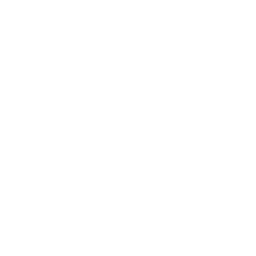

In [272]:
laplace_image = (laplace_x + laplace_y)
laplace_actual_relu = Image.fromarray(laplace_image.astype('uint8'))
laplace_actual_relu

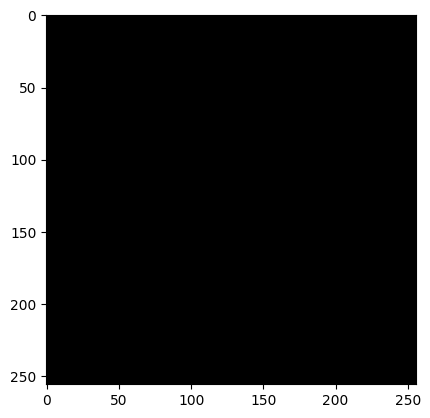

In [273]:
sobel_x = cv2.Sobel(laplace_image, cv2.CV_64F, 1, 0, ksize=3)

# Apply the Sobel filter in the y direction
sobel_y = cv2.Sobel(laplace_image, cv2.CV_64F, 0, 1, ksize=3)

# Compute the magnitude of the gradient
laplace_relu = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
plt.imshow(laplace_relu, cmap = "gray")

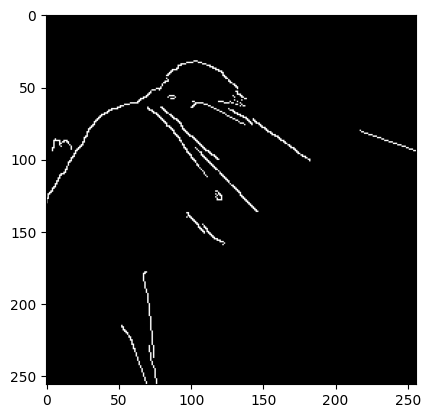

In [36]:
relu_img_gradient = cv2.Canny(y_image_values.astype('uint8'),50,150)
plt.imshow(relu_img_gradient, cmap = "gray")

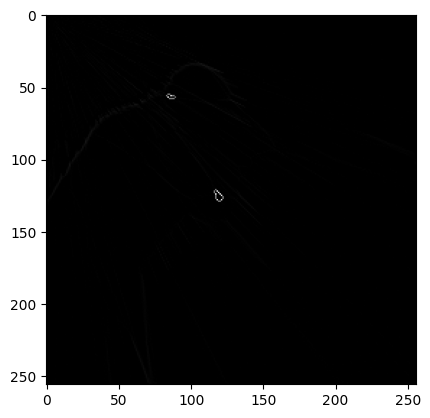

In [37]:
relu_img_laplacian = cv2.Laplacian(y_image_values.astype('uint8'),50,150)
plt.imshow(relu_img_laplacian, cmap = "gray")

In [151]:
siren_model = siren_mlp(256,4, 30).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(siren_model.parameters(), lr=0.0001)

In [152]:
siren_psnr = []

In [156]:
num_epochs = 15000
for e in tqdm(range(num_epochs)):
  y_pred_train = siren_model(torch.from_numpy(X.astype('float32')).to(device)).squeeze()
  loss = criterion(y_pred_train, torch.from_numpy(y.astype('float32')).to(device)) # loss is a tensor which stores the current value of train loss
  siren_psnr.append(20 * np.log10(1.0 / np.sqrt(loss.item())))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 100 == 0:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss
  if e == num_epochs-1:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss

  0%|          | 6/15000 [00:00<08:46, 28.47it/s]

Epoch [0/15000], Loss: 0.3287


  1%|          | 105/15000 [00:03<07:26, 33.34it/s]

Epoch [100/15000], Loss: 0.2874


  1%|▏         | 205/15000 [00:06<07:06, 34.66it/s]

Epoch [200/15000], Loss: 0.2765


  2%|▏         | 305/15000 [00:09<07:04, 34.61it/s]

Epoch [300/15000], Loss: 0.2576


  3%|▎         | 406/15000 [00:12<07:01, 34.61it/s]

Epoch [400/15000], Loss: 0.0790


  3%|▎         | 506/15000 [00:14<07:09, 33.78it/s]

Epoch [500/15000], Loss: 0.0502


  4%|▍         | 606/15000 [00:17<07:07, 33.66it/s]

Epoch [600/15000], Loss: 0.0377


  5%|▍         | 706/15000 [00:20<07:03, 33.75it/s]

Epoch [700/15000], Loss: 0.0305


  5%|▌         | 806/15000 [00:23<07:02, 33.61it/s]

Epoch [800/15000], Loss: 0.0263


  6%|▌         | 906/15000 [00:26<07:02, 33.38it/s]

Epoch [900/15000], Loss: 0.0222


  7%|▋         | 1006/15000 [00:29<07:03, 33.02it/s]

Epoch [1000/15000], Loss: 0.0198


  7%|▋         | 1106/15000 [00:32<06:59, 33.15it/s]

Epoch [1100/15000], Loss: 0.0181


  8%|▊         | 1206/15000 [00:35<06:56, 33.13it/s]

Epoch [1200/15000], Loss: 0.0164


  9%|▊         | 1306/15000 [00:38<06:55, 32.99it/s]

Epoch [1300/15000], Loss: 0.0154


  9%|▉         | 1406/15000 [00:41<06:50, 33.10it/s]

Epoch [1400/15000], Loss: 0.0143


 10%|█         | 1506/15000 [00:44<06:47, 33.13it/s]

Epoch [1500/15000], Loss: 0.0135


 11%|█         | 1606/15000 [00:48<06:45, 33.03it/s]

Epoch [1600/15000], Loss: 0.0130


 11%|█▏        | 1706/15000 [00:51<06:42, 33.00it/s]

Epoch [1700/15000], Loss: 0.0122


 12%|█▏        | 1806/15000 [00:54<06:39, 33.05it/s]

Epoch [1800/15000], Loss: 0.0117


 13%|█▎        | 1906/15000 [00:57<06:36, 33.04it/s]

Epoch [1900/15000], Loss: 0.0124


 13%|█▎        | 2006/15000 [01:00<06:32, 33.15it/s]

Epoch [2000/15000], Loss: 0.0109


 14%|█▍        | 2106/15000 [01:03<06:30, 33.03it/s]

Epoch [2100/15000], Loss: 0.0107


 15%|█▍        | 2206/15000 [01:06<06:21, 33.53it/s]

Epoch [2200/15000], Loss: 0.0104


 15%|█▌        | 2306/15000 [01:09<06:20, 33.39it/s]

Epoch [2300/15000], Loss: 0.0099


 16%|█▌        | 2406/15000 [01:12<06:16, 33.41it/s]

Epoch [2400/15000], Loss: 0.0098


 17%|█▋        | 2506/15000 [01:15<06:12, 33.50it/s]

Epoch [2500/15000], Loss: 0.0094


 17%|█▋        | 2606/15000 [01:18<06:10, 33.45it/s]

Epoch [2600/15000], Loss: 0.0092


 18%|█▊        | 2706/15000 [01:21<06:05, 33.62it/s]

Epoch [2700/15000], Loss: 0.0091


 19%|█▊        | 2806/15000 [01:24<06:00, 33.80it/s]

Epoch [2800/15000], Loss: 0.0089


 19%|█▉        | 2906/15000 [01:27<05:58, 33.70it/s]

Epoch [2900/15000], Loss: 0.0089


 20%|██        | 3006/15000 [01:30<05:54, 33.79it/s]

Epoch [3000/15000], Loss: 0.0086


 21%|██        | 3106/15000 [01:32<05:52, 33.76it/s]

Epoch [3100/15000], Loss: 0.0087


 21%|██▏       | 3206/15000 [01:35<05:50, 33.62it/s]

Epoch [3200/15000], Loss: 0.0082


 22%|██▏       | 3306/15000 [01:38<05:46, 33.73it/s]

Epoch [3300/15000], Loss: 0.0083


 23%|██▎       | 3406/15000 [01:41<05:43, 33.72it/s]

Epoch [3400/15000], Loss: 0.0082


 23%|██▎       | 3506/15000 [01:44<05:43, 33.43it/s]

Epoch [3500/15000], Loss: 0.0079


 24%|██▍       | 3606/15000 [01:47<05:38, 33.66it/s]

Epoch [3600/15000], Loss: 0.0089


 25%|██▍       | 3706/15000 [01:50<05:35, 33.62it/s]

Epoch [3700/15000], Loss: 0.0077


 25%|██▌       | 3806/15000 [01:53<05:33, 33.54it/s]

Epoch [3800/15000], Loss: 0.0086


 26%|██▌       | 3906/15000 [01:56<05:31, 33.42it/s]

Epoch [3900/15000], Loss: 0.0081


 27%|██▋       | 4006/15000 [01:59<05:27, 33.55it/s]

Epoch [4000/15000], Loss: 0.0075


 27%|██▋       | 4106/15000 [02:02<05:27, 33.25it/s]

Epoch [4100/15000], Loss: 0.0074


 28%|██▊       | 4206/15000 [02:05<05:25, 33.20it/s]

Epoch [4200/15000], Loss: 0.0073


 29%|██▊       | 4306/15000 [02:08<05:21, 33.26it/s]

Epoch [4300/15000], Loss: 0.0074


 29%|██▉       | 4406/15000 [02:11<05:18, 33.25it/s]

Epoch [4400/15000], Loss: 0.0072


 30%|███       | 4506/15000 [02:14<05:16, 33.21it/s]

Epoch [4500/15000], Loss: 0.0071


 31%|███       | 4606/15000 [02:17<05:11, 33.33it/s]

Epoch [4600/15000], Loss: 0.0071


 31%|███▏      | 4706/15000 [02:20<05:10, 33.18it/s]

Epoch [4700/15000], Loss: 0.0070


 32%|███▏      | 4806/15000 [02:23<05:05, 33.32it/s]

Epoch [4800/15000], Loss: 0.0069


 33%|███▎      | 4906/15000 [02:26<05:01, 33.52it/s]

Epoch [4900/15000], Loss: 0.0074


 33%|███▎      | 5006/15000 [02:29<04:59, 33.39it/s]

Epoch [5000/15000], Loss: 0.0075


 34%|███▍      | 5106/15000 [02:32<04:55, 33.45it/s]

Epoch [5100/15000], Loss: 0.0070


 35%|███▍      | 5206/15000 [02:35<04:54, 33.22it/s]

Epoch [5200/15000], Loss: 0.0069


 35%|███▌      | 5306/15000 [02:38<04:49, 33.52it/s]

Epoch [5300/15000], Loss: 0.0067


 36%|███▌      | 5406/15000 [02:41<04:46, 33.51it/s]

Epoch [5400/15000], Loss: 0.0067


 37%|███▋      | 5506/15000 [02:44<04:43, 33.54it/s]

Epoch [5500/15000], Loss: 0.0066


 37%|███▋      | 5606/15000 [02:47<04:41, 33.34it/s]

Epoch [5600/15000], Loss: 0.0066


 38%|███▊      | 5706/15000 [02:50<04:35, 33.74it/s]

Epoch [5700/15000], Loss: 0.0065


 39%|███▊      | 5806/15000 [02:53<04:35, 33.37it/s]

Epoch [5800/15000], Loss: 0.0065


 39%|███▉      | 5906/15000 [02:56<04:32, 33.39it/s]

Epoch [5900/15000], Loss: 0.0065


 40%|████      | 6006/15000 [02:59<04:29, 33.39it/s]

Epoch [6000/15000], Loss: 0.0075


 41%|████      | 6106/15000 [03:02<04:24, 33.57it/s]

Epoch [6100/15000], Loss: 0.0068


 41%|████▏     | 6206/15000 [03:05<04:22, 33.53it/s]

Epoch [6200/15000], Loss: 0.0067


 42%|████▏     | 6306/15000 [03:08<04:19, 33.53it/s]

Epoch [6300/15000], Loss: 0.0065


 43%|████▎     | 6406/15000 [03:11<04:15, 33.63it/s]

Epoch [6400/15000], Loss: 0.0064


 43%|████▎     | 6506/15000 [03:14<04:17, 33.02it/s]

Epoch [6500/15000], Loss: 0.0062


 44%|████▍     | 6606/15000 [03:17<04:10, 33.48it/s]

Epoch [6600/15000], Loss: 0.0063


 45%|████▍     | 6706/15000 [03:20<04:07, 33.48it/s]

Epoch [6700/15000], Loss: 0.0063


 45%|████▌     | 6806/15000 [03:23<04:04, 33.50it/s]

Epoch [6800/15000], Loss: 0.0062


 46%|████▌     | 6906/15000 [03:26<04:01, 33.56it/s]

Epoch [6900/15000], Loss: 0.0063


 47%|████▋     | 7006/15000 [03:29<03:58, 33.45it/s]

Epoch [7000/15000], Loss: 0.0066


 47%|████▋     | 7106/15000 [03:32<03:55, 33.47it/s]

Epoch [7100/15000], Loss: 0.0062


 48%|████▊     | 7206/15000 [03:35<03:55, 33.10it/s]

Epoch [7200/15000], Loss: 0.0061


 49%|████▊     | 7306/15000 [03:38<03:50, 33.38it/s]

Epoch [7300/15000], Loss: 0.0060


 49%|████▉     | 7406/15000 [03:41<03:46, 33.50it/s]

Epoch [7400/15000], Loss: 0.0067


 50%|█████     | 7506/15000 [03:44<03:43, 33.53it/s]

Epoch [7500/15000], Loss: 0.0062


 51%|█████     | 7606/15000 [03:47<03:40, 33.47it/s]

Epoch [7600/15000], Loss: 0.0062


 51%|█████▏    | 7706/15000 [03:50<03:39, 33.23it/s]

Epoch [7700/15000], Loss: 0.0060


 52%|█████▏    | 7806/15000 [03:53<03:36, 33.26it/s]

Epoch [7800/15000], Loss: 0.0064


 53%|█████▎    | 7906/15000 [03:56<03:32, 33.31it/s]

Epoch [7900/15000], Loss: 0.0059


 53%|█████▎    | 8006/15000 [03:59<03:28, 33.58it/s]

Epoch [8000/15000], Loss: 0.0067


 54%|█████▍    | 8106/15000 [04:02<03:27, 33.30it/s]

Epoch [8100/15000], Loss: 0.0060


 55%|█████▍    | 8206/15000 [04:05<03:22, 33.54it/s]

Epoch [8200/15000], Loss: 0.0060


 55%|█████▌    | 8306/15000 [04:08<03:20, 33.38it/s]

Epoch [8300/15000], Loss: 0.0060


 56%|█████▌    | 8406/15000 [04:11<03:17, 33.43it/s]

Epoch [8400/15000], Loss: 0.0059


 57%|█████▋    | 8506/15000 [04:14<03:13, 33.55it/s]

Epoch [8500/15000], Loss: 0.0058


 57%|█████▋    | 8606/15000 [04:17<03:11, 33.35it/s]

Epoch [8600/15000], Loss: 0.0060


 58%|█████▊    | 8706/15000 [04:20<03:09, 33.30it/s]

Epoch [8700/15000], Loss: 0.0058


 59%|█████▊    | 8806/15000 [04:23<03:05, 33.42it/s]

Epoch [8800/15000], Loss: 0.0058


 59%|█████▉    | 8906/15000 [04:26<03:03, 33.24it/s]

Epoch [8900/15000], Loss: 0.0059


 60%|██████    | 9006/15000 [04:29<03:00, 33.17it/s]

Epoch [9000/15000], Loss: 0.0059


 61%|██████    | 9106/15000 [04:32<02:56, 33.36it/s]

Epoch [9100/15000], Loss: 0.0060


 61%|██████▏   | 9206/15000 [04:35<02:53, 33.37it/s]

Epoch [9200/15000], Loss: 0.0064


 62%|██████▏   | 9306/15000 [04:38<02:50, 33.43it/s]

Epoch [9300/15000], Loss: 0.0062


 63%|██████▎   | 9406/15000 [04:41<02:46, 33.68it/s]

Epoch [9400/15000], Loss: 0.0059


 63%|██████▎   | 9506/15000 [04:44<02:44, 33.38it/s]

Epoch [9500/15000], Loss: 0.0060


 64%|██████▍   | 9606/15000 [04:47<02:41, 33.45it/s]

Epoch [9600/15000], Loss: 0.0057


 65%|██████▍   | 9706/15000 [04:50<02:39, 33.23it/s]

Epoch [9700/15000], Loss: 0.0056


 65%|██████▌   | 9806/15000 [04:53<02:35, 33.41it/s]

Epoch [9800/15000], Loss: 0.0056


 66%|██████▌   | 9906/15000 [04:56<02:32, 33.42it/s]

Epoch [9900/15000], Loss: 0.0056


 67%|██████▋   | 10006/15000 [04:59<02:28, 33.52it/s]

Epoch [10000/15000], Loss: 0.0056


 67%|██████▋   | 10106/15000 [05:02<02:27, 33.19it/s]

Epoch [10100/15000], Loss: 0.0060


 68%|██████▊   | 10206/15000 [05:05<02:23, 33.49it/s]

Epoch [10200/15000], Loss: 0.0059


 69%|██████▊   | 10306/15000 [05:08<02:20, 33.48it/s]

Epoch [10300/15000], Loss: 0.0059


 69%|██████▉   | 10406/15000 [05:11<02:17, 33.37it/s]

Epoch [10400/15000], Loss: 0.0055


 70%|███████   | 10506/15000 [05:14<02:13, 33.61it/s]

Epoch [10500/15000], Loss: 0.0056


 71%|███████   | 10606/15000 [05:17<02:11, 33.36it/s]

Epoch [10600/15000], Loss: 0.0059


 71%|███████▏  | 10706/15000 [05:20<02:09, 33.14it/s]

Epoch [10700/15000], Loss: 0.0056


 72%|███████▏  | 10806/15000 [05:23<02:05, 33.48it/s]

Epoch [10800/15000], Loss: 0.0057


 73%|███████▎  | 10906/15000 [05:26<02:01, 33.61it/s]

Epoch [10900/15000], Loss: 0.0055


 73%|███████▎  | 11006/15000 [05:29<01:59, 33.36it/s]

Epoch [11000/15000], Loss: 0.0057


 74%|███████▍  | 11106/15000 [05:32<01:56, 33.41it/s]

Epoch [11100/15000], Loss: 0.0057


 75%|███████▍  | 11206/15000 [05:35<01:54, 33.25it/s]

Epoch [11200/15000], Loss: 0.0057


 75%|███████▌  | 11306/15000 [05:38<01:50, 33.37it/s]

Epoch [11300/15000], Loss: 0.0055


 76%|███████▌  | 11406/15000 [05:41<01:47, 33.37it/s]

Epoch [11400/15000], Loss: 0.0057


 77%|███████▋  | 11506/15000 [05:44<01:44, 33.47it/s]

Epoch [11500/15000], Loss: 0.0055


 77%|███████▋  | 11606/15000 [05:47<01:41, 33.39it/s]

Epoch [11600/15000], Loss: 0.0054


 78%|███████▊  | 11706/15000 [05:50<01:38, 33.46it/s]

Epoch [11700/15000], Loss: 0.0059


 79%|███████▊  | 11806/15000 [05:53<01:35, 33.37it/s]

Epoch [11800/15000], Loss: 0.0055


 79%|███████▉  | 11906/15000 [05:56<01:32, 33.58it/s]

Epoch [11900/15000], Loss: 0.0054


 80%|████████  | 12006/15000 [05:59<01:29, 33.33it/s]

Epoch [12000/15000], Loss: 0.0063


 81%|████████  | 12106/15000 [06:02<01:26, 33.27it/s]

Epoch [12100/15000], Loss: 0.0054


 81%|████████▏ | 12206/15000 [06:05<01:24, 33.00it/s]

Epoch [12200/15000], Loss: 0.0054


 82%|████████▏ | 12306/15000 [06:08<01:20, 33.32it/s]

Epoch [12300/15000], Loss: 0.0056


 83%|████████▎ | 12406/15000 [06:11<01:17, 33.46it/s]

Epoch [12400/15000], Loss: 0.0055


 83%|████████▎ | 12506/15000 [06:14<01:14, 33.51it/s]

Epoch [12500/15000], Loss: 0.0054


 84%|████████▍ | 12606/15000 [06:17<01:11, 33.30it/s]

Epoch [12600/15000], Loss: 0.0058


 85%|████████▍ | 12706/15000 [06:20<01:08, 33.43it/s]

Epoch [12700/15000], Loss: 0.0061


 85%|████████▌ | 12806/15000 [06:23<01:05, 33.27it/s]

Epoch [12800/15000], Loss: 0.0055


 86%|████████▌ | 12906/15000 [06:26<01:02, 33.49it/s]

Epoch [12900/15000], Loss: 0.0053


 87%|████████▋ | 13006/15000 [06:29<01:00, 33.08it/s]

Epoch [13000/15000], Loss: 0.0053


 87%|████████▋ | 13106/15000 [06:32<00:56, 33.52it/s]

Epoch [13100/15000], Loss: 0.0054


 88%|████████▊ | 13206/15000 [06:35<00:53, 33.28it/s]

Epoch [13200/15000], Loss: 0.0055


 89%|████████▊ | 13306/15000 [06:38<00:50, 33.31it/s]

Epoch [13300/15000], Loss: 0.0054


 89%|████████▉ | 13406/15000 [06:41<00:47, 33.54it/s]

Epoch [13400/15000], Loss: 0.0059


 90%|█████████ | 13506/15000 [06:44<00:44, 33.44it/s]

Epoch [13500/15000], Loss: 0.0055


 91%|█████████ | 13606/15000 [06:47<00:41, 33.41it/s]

Epoch [13600/15000], Loss: 0.0052


 91%|█████████▏| 13706/15000 [06:50<00:38, 33.33it/s]

Epoch [13700/15000], Loss: 0.0052


 92%|█████████▏| 13806/15000 [06:53<00:35, 33.48it/s]

Epoch [13800/15000], Loss: 0.0052


 93%|█████████▎| 13906/15000 [06:56<00:32, 33.25it/s]

Epoch [13900/15000], Loss: 0.0053


 93%|█████████▎| 14006/15000 [06:59<00:29, 33.43it/s]

Epoch [14000/15000], Loss: 0.0055


 94%|█████████▍| 14106/15000 [07:02<00:26, 33.49it/s]

Epoch [14100/15000], Loss: 0.0053


 95%|█████████▍| 14206/15000 [07:05<00:23, 33.43it/s]

Epoch [14200/15000], Loss: 0.0054


 95%|█████████▌| 14306/15000 [07:08<00:20, 33.43it/s]

Epoch [14300/15000], Loss: 0.0053


 96%|█████████▌| 14406/15000 [07:11<00:17, 33.52it/s]

Epoch [14400/15000], Loss: 0.0057


 97%|█████████▋| 14506/15000 [07:14<00:14, 33.51it/s]

Epoch [14500/15000], Loss: 0.0055


 97%|█████████▋| 14606/15000 [07:17<00:11, 33.26it/s]

Epoch [14600/15000], Loss: 0.0053


 98%|█████████▊| 14706/15000 [07:20<00:08, 33.48it/s]

Epoch [14700/15000], Loss: 0.0052


 99%|█████████▊| 14806/15000 [07:23<00:05, 33.36it/s]

Epoch [14800/15000], Loss: 0.0053


 99%|█████████▉| 14906/15000 [07:26<00:02, 33.57it/s]

Epoch [14900/15000], Loss: 0.0052


100%|██████████| 15000/15000 [07:28<00:00, 33.42it/s]


Epoch [14999/15000], Loss: 0.0052


In [207]:
len(siren_psnr)

15000

In [274]:
y_preds = siren_model(torch.from_numpy(X.astype('float32')).to(device))

In [275]:
y_image_values = (y_preds.cpu().detach().numpy().reshape(256,256)*127.5)+127.5
y_image_values

array([[174.25607 , 187.44972 , 195.51678 , ..., 190.1547  , 192.02853 ,
        185.45285 ],
       [182.28305 , 196.42154 , 199.7844  , ..., 190.81375 , 191.92902 ,
        188.73192 ],
       [195.37546 , 204.89066 , 202.77034 , ..., 188.61707 , 189.85379 ,
        188.57394 ],
       ...,
       [ 22.314804,  21.750534,  21.049118, ..., 144.78046 , 141.20758 ,
        138.22868 ],
       [ 18.42949 ,  23.628326,  23.565216, ..., 147.55804 , 144.30429 ,
        141.01857 ],
       [ 20.546638,  26.490067,  28.919807, ..., 147.93472 , 145.34448 ,
        144.75308 ]], dtype=float32)

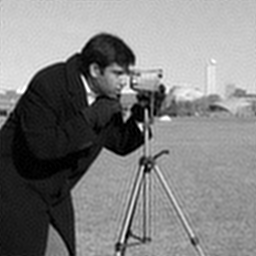

In [276]:
siren_img = Image.fromarray(y_image_values)
siren_img.show()

In [277]:
X_temp = torch.tensor(X.astype('float32'), requires_grad = True).to(device)
y_preds = siren_model(X_temp).to(device)

In [278]:
grad_ = torch.autograd.grad(y_preds, X_temp,grad_outputs = torch.ones_like(y_preds), create_graph=True)[0]

In [279]:
type(grad_), grad_.shape

(torch.Tensor, torch.Size([65536, 2]))

In [280]:
grad_array = grad_.cpu().detach().numpy()
grad_array

array([[ 0.02254076,  0.12707354],
       [ 0.05271673,  0.08095489],
       [ 0.0313831 ,  0.04806922],
       ...,
       [-0.00497925, -0.0401907 ],
       [-0.01075941, -0.00360381],
       [ 0.0109614 , -0.0175011 ]], dtype=float32)

In [282]:
grad_array.shape

(65536, 2)

In [283]:
grad_x = grad_array[:, 0].reshape(-1, 1)
grad_y = grad_array[:, 1].reshape(-1, 1)

In [284]:
grad_x = grad_x.reshape(256,256)
grad_y = grad_y.reshape(256,256)
grad_x = (grad_x*127.5) + 127.5
grad_y = (grad_y*127.5) + 127.5

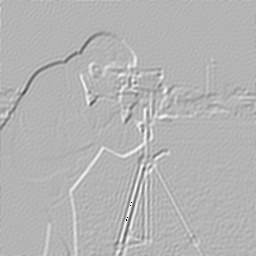

In [285]:
gradient_image = np.sqrt(grad_x**2 + grad_y**2)
gradient_actual_siren = Image.fromarray(gradient_image.astype('uint8'))
gradient_actual_siren

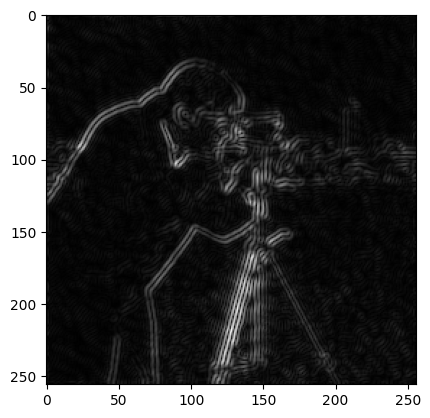

In [286]:
sobel_x = cv2.Sobel(gradient_image, cv2.CV_64F, 1, 0, ksize=3)

# Apply the Sobel filter in the y direction
sobel_y = cv2.Sobel(gradient_image, cv2.CV_64F, 0, 1, ksize=3)

# Compute the magnitude of the gradient
gradient_siren = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
plt.imshow(gradient_siren, cmap = "gray")

In [287]:
laplace = torch.autograd.grad(torch.sum(grad_), X_temp)[0]

In [288]:
laplace

tensor([[ 0.1522,  0.0199],
        [ 0.0384, -0.0440],
        [-0.0296, -0.0568],
        ...,
        [-0.0321,  0.0149],
        [-0.0263,  0.0323],
        [-0.0259, -0.0243]], device='cuda:0')

In [289]:
laplace.shape

torch.Size([65536, 2])

In [290]:
laplace_array = laplace.cpu().detach().numpy()
laplace_array

array([[ 0.15218748,  0.01987518],
       [ 0.03843903, -0.04398586],
       [-0.02956406, -0.05680995],
       ...,
       [-0.03207904,  0.01488304],
       [-0.02628506,  0.0323014 ],
       [-0.02590293, -0.02425996]], dtype=float32)

In [292]:
laplace_array.shape

(65536, 2)

In [293]:
laplace_x = laplace_array[:, 0].reshape(-1, 1)
laplace_y = laplace_array[:, 1].reshape(-1, 1)

In [294]:
laplace_x = laplace_x.reshape(256,256)
laplace_y = laplace_y.reshape(256,256)
laplace_x = (laplace_x*127.5) + 127.5
laplace_y = (laplace_y*127.5) + 127.5

In [301]:
laplace_image

array([[276.938  , 254.29277, 243.9873 , ..., 241.24025, 237.519  ,
        243.6709 ],
       [248.56888, 233.72612, 240.21072, ..., 250.2706 , 250.01196,
        255.04953],
       [214.16837, 221.1969 , 244.1391 , ..., 259.84967, 258.72858,
        256.68777],
       ...,
       [269.3421 , 260.34256, 252.77129, ..., 252.50424, 256.51947,
        257.24442],
       [263.63666, 256.88626, 256.56168, ..., 254.06711, 257.1623 ,
        253.5746 ],
       [253.22858, 256.43646, 263.96027, ..., 252.8075 , 255.76709,
        248.60422]], dtype=float32)

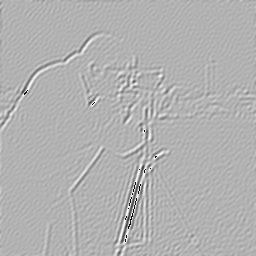

In [318]:
laplace_image = 0.7*(laplace_x + laplace_y)
laplace_actual_siren = Image.fromarray(laplace_image.astype('uint8'))
laplace_actual_siren

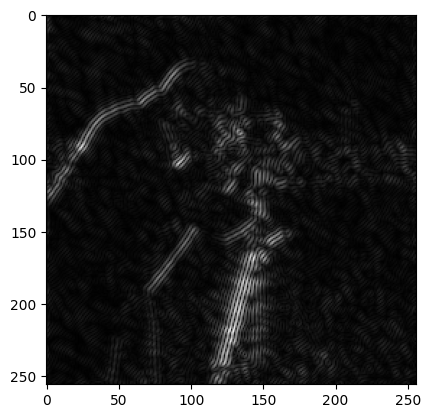

In [319]:
sobel_x = cv2.Sobel(laplace_image, cv2.CV_64F, 1, 0, ksize=1)

# Apply the Sobel filter in the y direction
sobel_y = cv2.Sobel(laplace_image, cv2.CV_64F, 0, 1, ksize=1)

# Compute the magnitude of the gradient
laplace_siren = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
plt.imshow(laplace_siren, cmap = "gray")

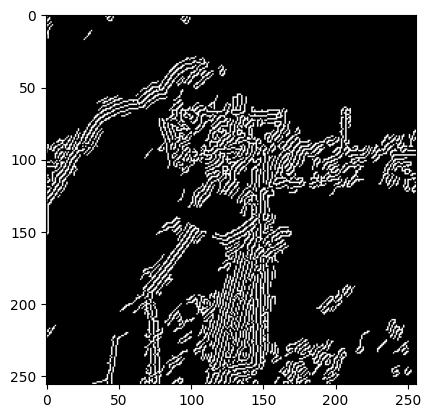

In [320]:
siren_img_gradient = cv2.Canny(laplace_image.astype('uint8'),50,150)
plt.imshow(siren_img_gradient, cmap = "gray")

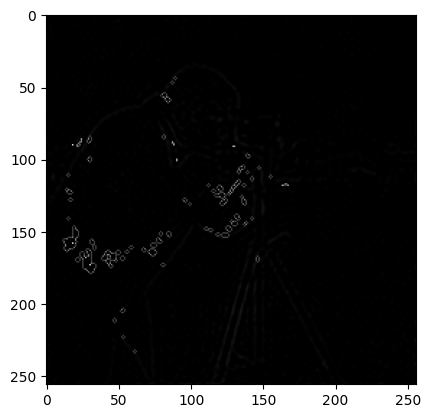

In [ ]:
siren_img_laplacian = cv2.Laplacian(y_image_values.astype('uint8'),50,150)
plt.imshow(siren_img_laplacian, cmap = "gray")

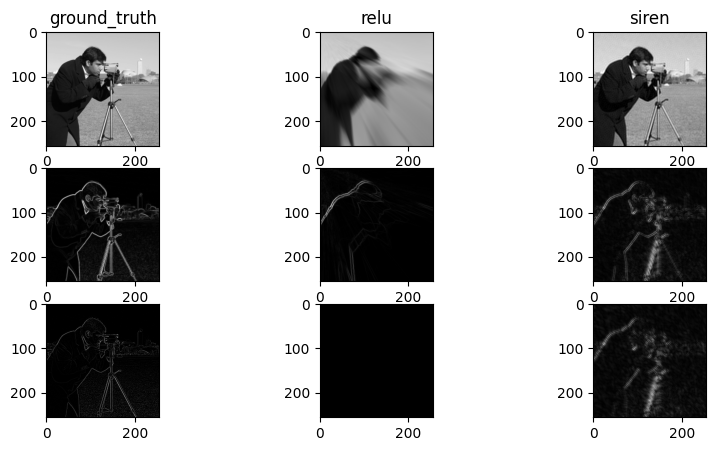

In [322]:
fig,ax = plt.subplots(3,3, figsize = (10,5))
ax[0,0].imshow(image_array, cmap = "gray")
ax[1,0].imshow(mag, cmap = "gray")
ax[2,0].imshow(img_laplacian,cmap = "gray")
ax[0,1].imshow(relu_img,cmap = "gray")
ax[1,1].imshow(grad_relu,cmap = "gray")
ax[2,1].imshow(laplace_relu,cmap = "gray")
ax[0,2].imshow(siren_img,cmap = "gray")
ax[1,2].imshow(gradient_siren, cmap = 'gray')
ax[2,2].imshow(laplace_siren, cmap = "gray")
ax[0,0].set(title = 'ground_truth')
ax[0,1].set(title = 'relu')
ax[0,2].set(title = 'siren')
plt.show()

In [323]:
gradient_siren

array([[  0.        ,  53.88964844,  42.92962646, ...,   8.11456299,
         24.07327271,   0.        ],
       [  1.93447876,  73.24142761,  49.21481219, ...,  20.36964468,
         20.47626699,   3.62506104],
       [ 68.27593994, 105.92250913,  45.2828613 , ...,  13.45067995,
         20.45025439,  19.62374878],
       ...,
       [ 29.29849243,  21.86544689,   6.93682911, ...,  12.30016871,
         10.72612586,  14.96844482],
       [ 36.52456665,  29.42473434,  23.96041171, ...,  11.05378291,
          6.16011252,   2.57751465],
       [  0.        ,  14.72579956,   1.73321533, ...,   4.78436279,
         10.93673706,   0.        ]])

In [324]:
laplace_siren

array([[ 0.        , 23.06547546,  6.24958801, ...,  4.97402954,
         1.70144653,  0.        ],
       [43.93873596, 23.89447566, 11.67022256, ..., 13.30208318,
        15.21891818,  9.11181641],
       [32.84587097, 21.05112614, 27.89993482, ...,  6.60679799,
         4.04857695,  2.9259491 ],
       ...,
       [ 2.22979736, 12.14950832,  6.15351772, ...,  7.09728362,
         6.14091152,  0.39274597],
       [11.27947998,  5.65714783,  8.39254515, ...,  4.09510536,
         0.62947694,  6.04814148],
       [ 0.        ,  7.51219177,  7.96183777, ...,  6.6729126 ,
         2.94229126,  0.        ]])

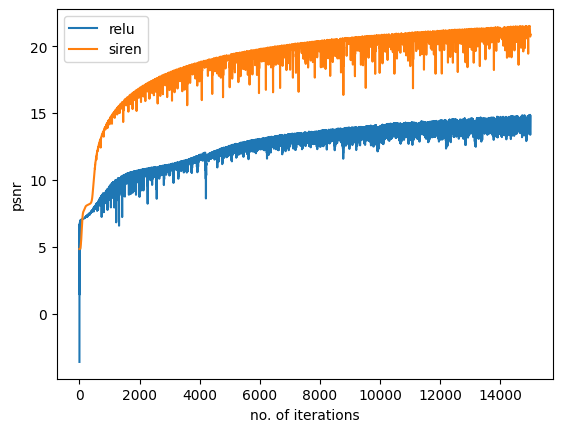

In [ ]:
plt.xlabel('no. of iterations')
plt.ylabel('psnr')
plt.plot(range(15000), relu_psnr, label = 'relu')
plt.plot(range(15000), siren_psnr, label = 'siren')
plt.legend()
plt.show()